We will use the daily spreadsheet from EU CDC containing new cases and deaths per country per day.

In [1]:
!wget -N https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide.xlsx

--2020-09-18 16:26:15--  https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide.xlsx
Resolving www.ecdc.europa.eu (www.ecdc.europa.eu)... 13.227.219.122, 13.227.219.21, 13.227.219.109, ...
Connecting to www.ecdc.europa.eu (www.ecdc.europa.eu)|13.227.219.122|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘COVID-19-geographic-disbtribution-worldwide.xlsx’ not modified on server. Omitting download.



Get Pandas and NumPy for feature engineering and calculations and get plots inline.

In [2]:
import pandas as pd
import numpy  as np

from pyearth import Earth
from pyearth import export

#from jupyterthemes import jtplot
#jtplot.style(theme='onedork')

%matplotlib inline

We read our dataframe directly from the downloaded Excel file and have a look at the first 10 lines for format. Data for Namibia caused missing values because the `geoId` is __NA__, so we disable interpretation of missing values.

In [3]:
df = pd.read_excel('COVID-19-geographic-disbtribution-worldwide.xlsx', keep_default_na=False, na_values='')
df.head(10)

dateRep  day  month  year  cases  deaths countriesAndTerritories geoId  \
0 2020-09-18   18      9  2020      0       0             Afghanistan    AF   
1 2020-09-17   17      9  2020     17       0             Afghanistan    AF   
2 2020-09-16   16      9  2020     40      10             Afghanistan    AF   
3 2020-09-15   15      9  2020     99       6             Afghanistan    AF   
4 2020-09-14   14      9  2020     75       0             Afghanistan    AF   
5 2020-09-13   13      9  2020     35       0             Afghanistan    AF   
6 2020-09-12   12      9  2020     34       0             Afghanistan    AF   
7 2020-09-11   11      9  2020     28       0             Afghanistan    AF   
8 2020-09-10   10      9  2020     24       2             Afghanistan    AF   
9 2020-09-09    9      9  2020     26       3             Afghanistan    AF   

  countryterritoryCode  popData2019 continentExp  \
0                  AFG   38041757.0         Asia   
1                  AFG   38041757.0         Asia   
2                  AFG   38041757.0         Asia   
3                  AFG   38041757.0         Asia   
4                  AFG   38041757.0         Asia   
5                  AFG   38041757.0         Asia   
6                  AFG   38041757.0         Asia   
7                  AFG   38041757.0         Asia   
8                  AFG   38041757.0         Asia   
9                  AFG   38041757.0         Asia   

   Cumulative_number_for_14_days_of_COVID-19_cases_per_100000  
0                                           1.535155           
1                                           1.653446           
2                                           1.708649           
3                                           1.627159           
4                                           1.456294           
5                                           1.309088           
6                                           1.224970           
7                                           1.164510           
8                                           1.098793           
9                                           1.180282

Last check of our source dataframe.

In [4]:
df.count()

dateRep                                                       43509
day                                                           43509
month                                                         43509
year                                                          43509
cases                                                         43509
deaths                                                        43509
countriesAndTerritories                                       43509
geoId                                                         43509
countryterritoryCode                                          43445
popData2019                                                   43445
continentExp                                                  43509
Cumulative_number_for_14_days_of_COVID-19_cases_per_100000    40728
dtype: int64

We pivot to a country by column format.

In [5]:
df_geo = df.pivot_table(index=['dateRep'], columns='continentExp', values=['cases', 'deaths'], aggfunc='sum')
df_geo

cases                                            deaths  \
continentExp  Africa   America      Asia   Europe Oceania Other Africa   
dateRep                                                                  
2019-12-31       0.0       0.0      27.0      0.0     0.0   0.0    0.0   
2020-01-01       0.0       0.0       0.0      0.0     0.0   0.0    0.0   
2020-01-02       0.0       0.0       0.0      0.0     0.0   0.0    0.0   
2020-01-03       0.0       0.0      17.0      0.0     0.0   0.0    0.0   
2020-01-04       0.0       0.0       0.0      0.0     0.0   0.0    0.0   
...              ...       ...       ...      ...     ...   ...    ...   
2020-09-14    6674.0   87888.0  120640.0  57340.0    46.0   NaN  119.0   
2020-09-15    6339.0   82804.0  114073.0  39328.0   227.0   NaN  169.0   
2020-09-16    6518.0  123164.0  123908.0  49761.0   119.0   NaN  267.0   
2020-09-17    7490.0  103939.0  130848.0  47777.0   118.0   NaN  190.0   
2020-09-18    8751.0  117973.0  129025.0  42462.0   169.0   NaN  184.0   

                                                   
continentExp America    Asia Europe Oceania Other  
dateRep                                            
2019-12-31       0.0     0.0    0.0     0.0   0.0  
2020-01-01       0.0     0.0    0.0     0.0   0.0  
2020-01-02       0.0     0.0    0.0     0.0   0.0  
2020-01-03       0.0     0.0    0.0     0.0   0.0  
2020-01-04       0.0     0.0    0.0     0.0   0.0  
...              ...     ...    ...     ...   ...  
2020-09-14    1639.0  1705.0  410.0     7.0   NaN  
2020-09-15    1724.0  1892.0  441.0     8.0   NaN  
2020-09-16    3955.0  1938.0  795.0     1.0   NaN  
2020-09-17    2881.0  1817.0  537.0    10.0   NaN  
2020-09-18    2748.0  1822.0  443.0    10.0   NaN  

[263 rows x 12 columns]

For predictions later on we need extra rows in our dataframe. One of the ways to do that is reindexing with a larger range, so we add to the current range and check our latest date.

In [6]:
new_index = pd.date_range(df_geo.index.min(), df_geo.index.max() + pd.Timedelta('365 days'))
df_geo = df_geo.reindex(new_index)
df_geo

cases                                    deaths               \
continentExp Africa America  Asia Europe Oceania Other Africa America Asia   
2019-12-31      0.0     0.0  27.0    0.0     0.0   0.0    0.0     0.0  0.0   
2020-01-01      0.0     0.0   0.0    0.0     0.0   0.0    0.0     0.0  0.0   
2020-01-02      0.0     0.0   0.0    0.0     0.0   0.0    0.0     0.0  0.0   
2020-01-03      0.0     0.0  17.0    0.0     0.0   0.0    0.0     0.0  0.0   
2020-01-04      0.0     0.0   0.0    0.0     0.0   0.0    0.0     0.0  0.0   
...             ...     ...   ...    ...     ...   ...    ...     ...  ...   
2021-09-14      NaN     NaN   NaN    NaN     NaN   NaN    NaN     NaN  NaN   
2021-09-15      NaN     NaN   NaN    NaN     NaN   NaN    NaN     NaN  NaN   
2021-09-16      NaN     NaN   NaN    NaN     NaN   NaN    NaN     NaN  NaN   
2021-09-17      NaN     NaN   NaN    NaN     NaN   NaN    NaN     NaN  NaN   
2021-09-18      NaN     NaN   NaN    NaN     NaN   NaN    NaN     NaN  NaN   

                                   
continentExp Europe Oceania Other  
2019-12-31      0.0     0.0   0.0  
2020-01-01      0.0     0.0   0.0  
2020-01-02      0.0     0.0   0.0  
2020-01-03      0.0     0.0   0.0  
2020-01-04      0.0     0.0   0.0  
...             ...     ...   ...  
2021-09-14      NaN     NaN   NaN  
2021-09-15      NaN     NaN   NaN  
2021-09-16      NaN     NaN   NaN  
2021-09-17      NaN     NaN   NaN  
2021-09-18      NaN     NaN   NaN  

[628 rows x 12 columns]

We need numerical data as inputs for a model, so we add a column representing the date as days since the start of the index.

In [7]:
df_geo['daynum'] = (df_geo.index - df_geo.index.min()).days
df_geo['daynum'].describe()

count    628.000000
mean     313.500000
std      181.432265
min        0.000000
25%      156.750000
50%      313.500000
75%      470.250000
max      627.000000
Name: daynum, dtype: float64

We create a simple dataframe to contain the source values for our fitting approach. The typical progress of an outbreak seems to fit a Gumbel distribution, where the cumulative distribution is a double negative exponent: `exp(-exp(-x))`. The measures are averaged by week to smooth out reporting lags.

In [8]:
def gumpdf(x, beta, mu):
    """Return PDF value according to Gumbel"""
    expon = - ((x - mu) / beta)
    return(np.exp(expon) * np.exp(- (np.exp(expon))) / beta)

def gumcdf(x, beta, mu):
    """Return CDF value according to Gumbel"""
    expon = - ((x - mu) / beta)
    return(np.exp(- (np.exp(expon))))

In [9]:
import matplotlib as mpl
mpl.rc('figure', max_open_warning = 0)

Running multiple wave analysis for Africa
Minimum number of cases is 2
Wave 01 beta 13.107 with mu  98 from  87 to  95 for 20484
Wave 02 beta  2.736 with mu  69 from  70 to  75 for 99
Wave 03 beta 20.004 with mu 134 from 104 to 123 for 91757
Wave 04 beta  9.203 with mu 139 from 133 to 139 for 33158
Wave 05 beta  5.363 with mu 149 from 145 to 148 for 24448
Wave 06 beta  5.048 with mu 157 from 153 to 156 for 39460
Wave 07 beta  7.032 with mu 168 from 161 to 166 for 93493
Wave 08 beta  6.671 with mu 177 from 171 to 175 for 91464
Wave 09 beta 13.203 with mu 198 from 184 to 196 for 545829
Wave 10 beta  4.664 with mu 205 from 202 to 205 for 47073
Wave 11 beta  6.021 with mu 215 from 210 to 215 for 101548
Wave 12 beta  9.702 with mu 231 from 223 to 231 for 152096
Wave 13 beta  6.680 with mu 242 from 237 to 243 for 63301
Wave 14 beta  8.399 with mu 257 from 249 to 253 for 103059
Wave 15 beta  8.013 with mu 266 from 259 to 262 for 48891
--- no data left
Running multiple wave analysis for Americ

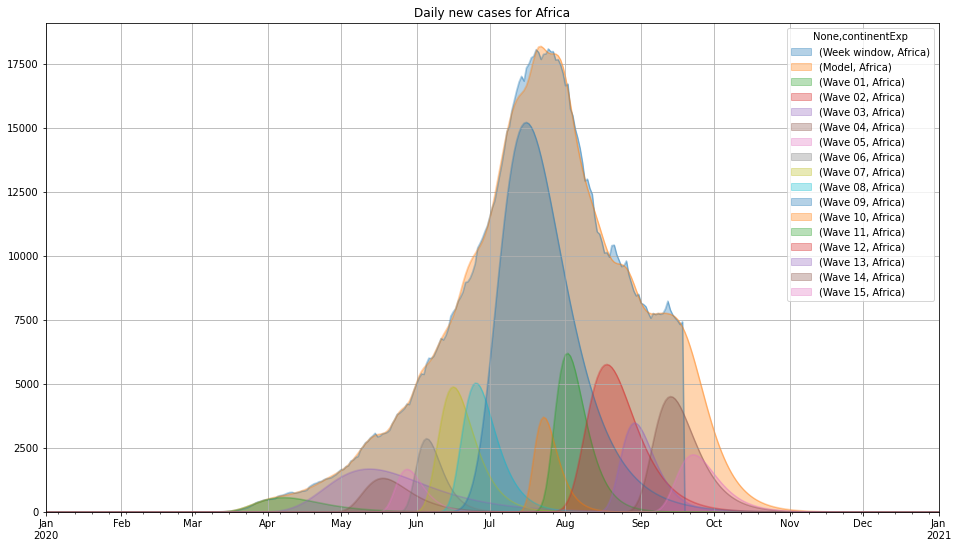

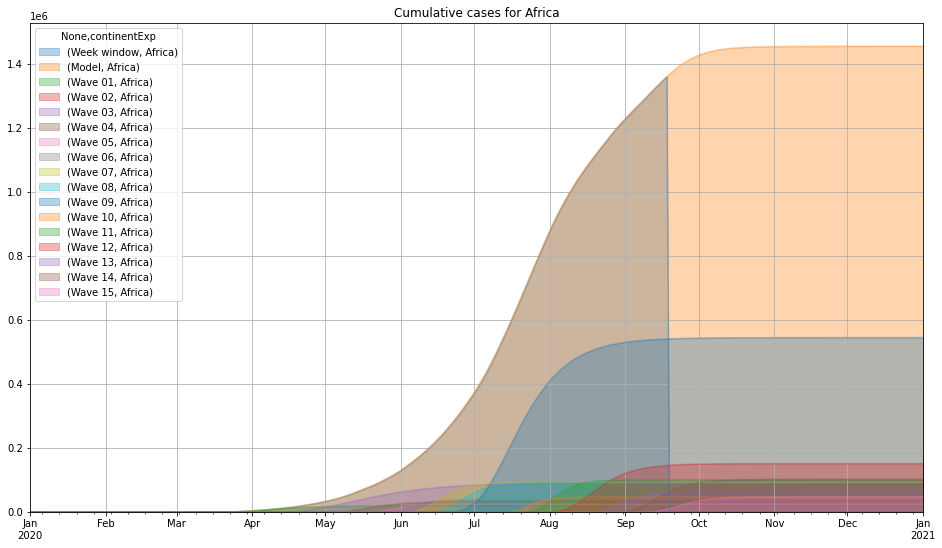

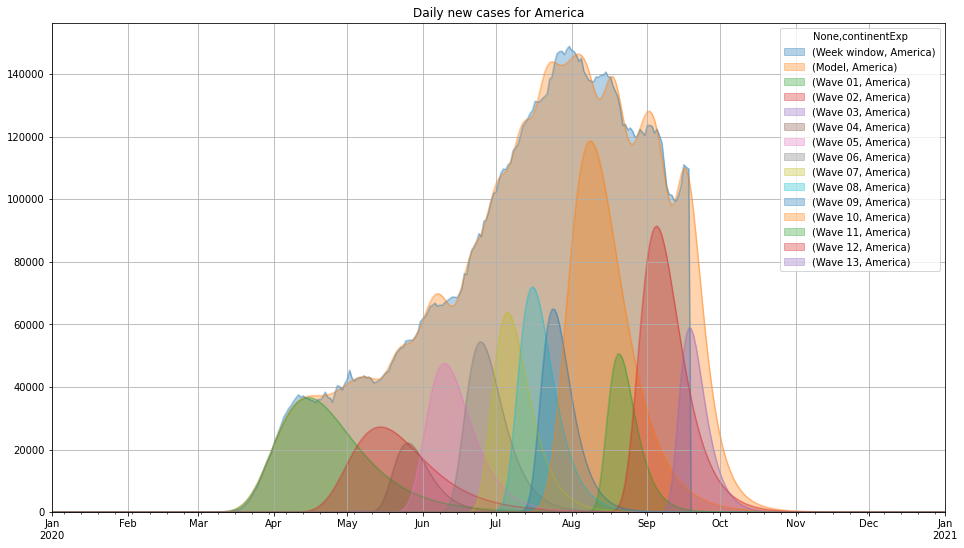

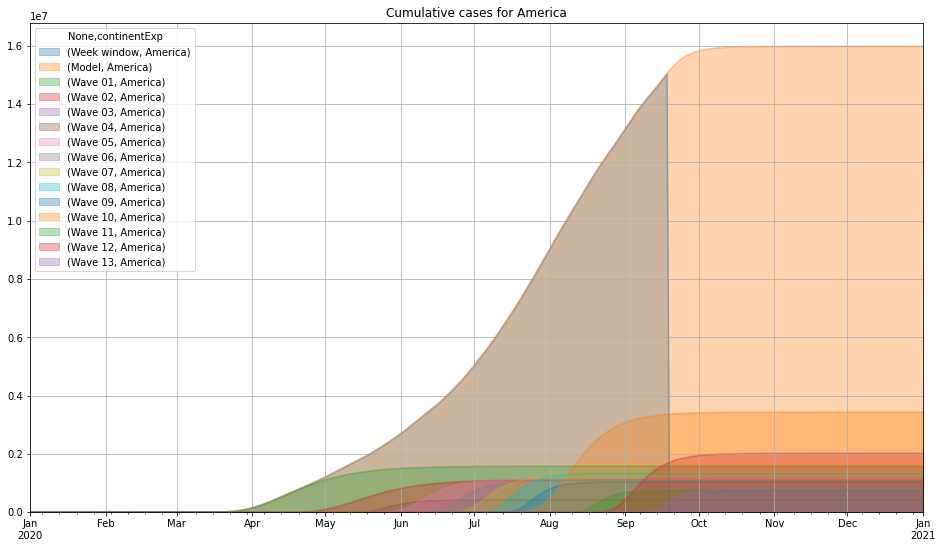

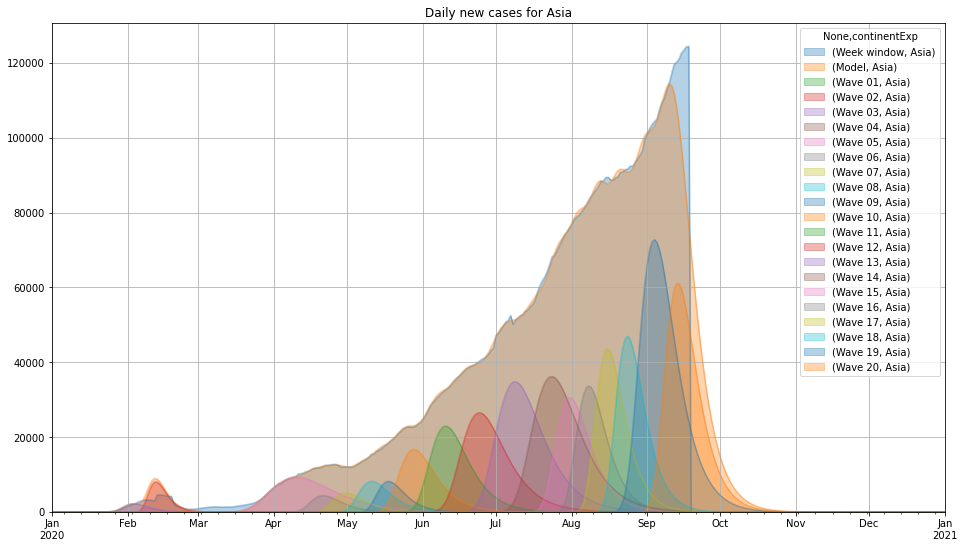

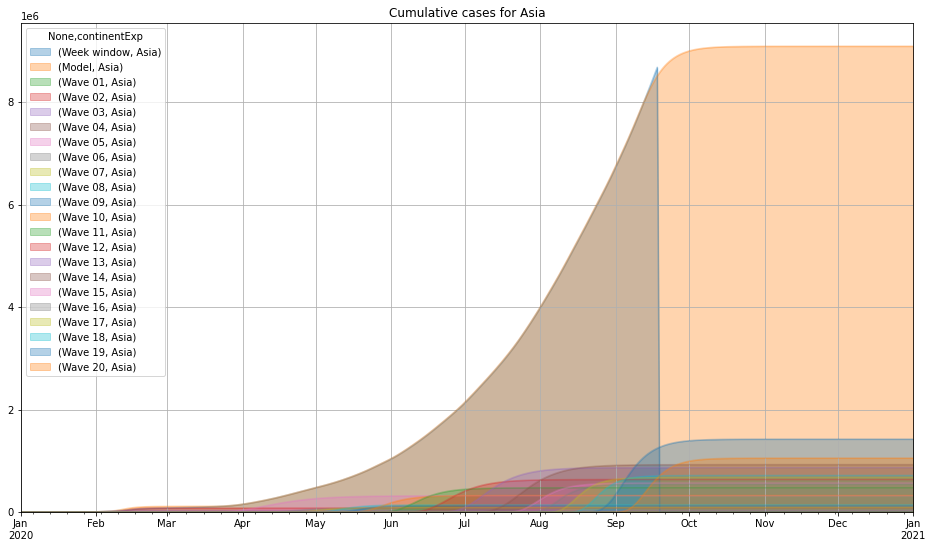

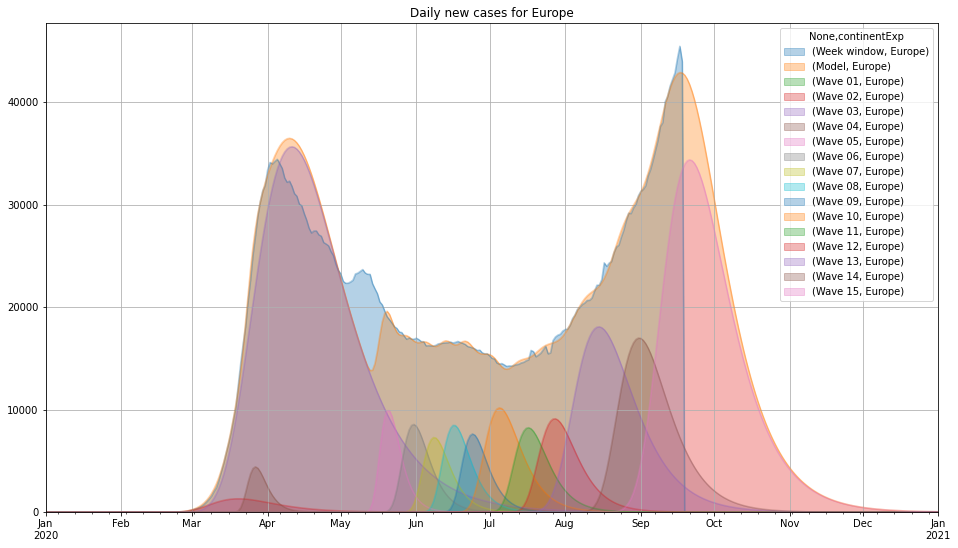

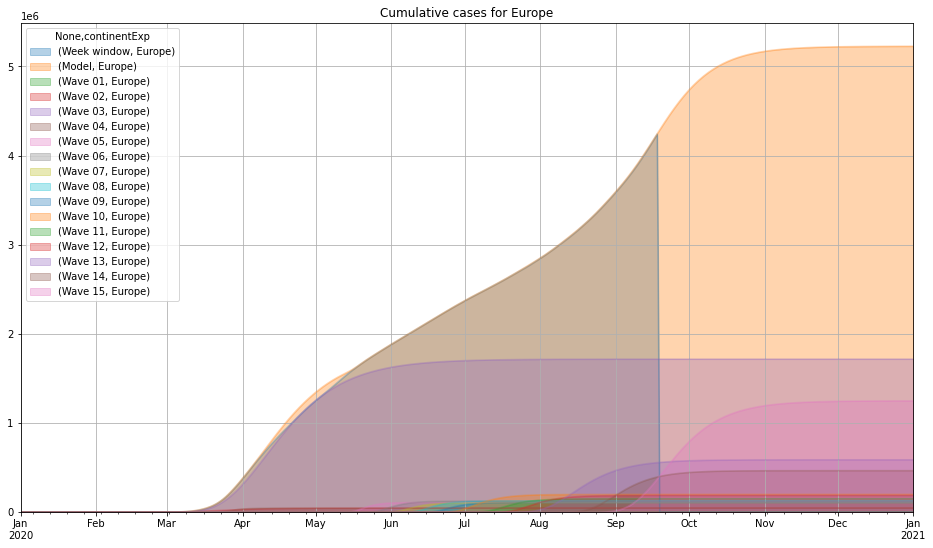

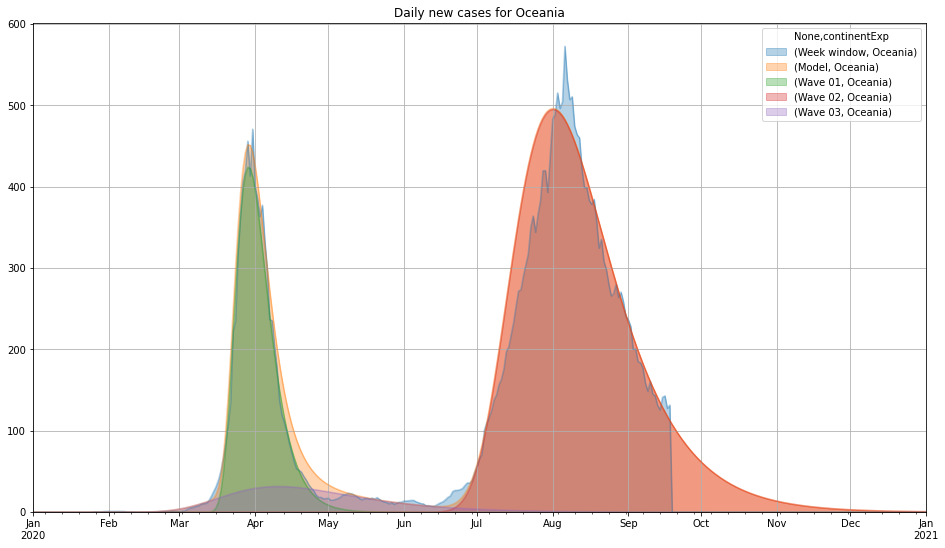

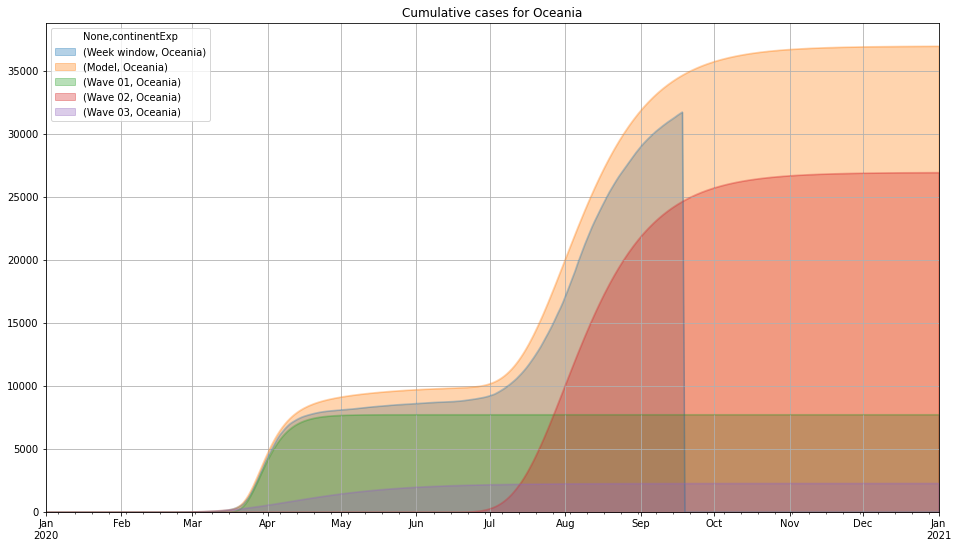

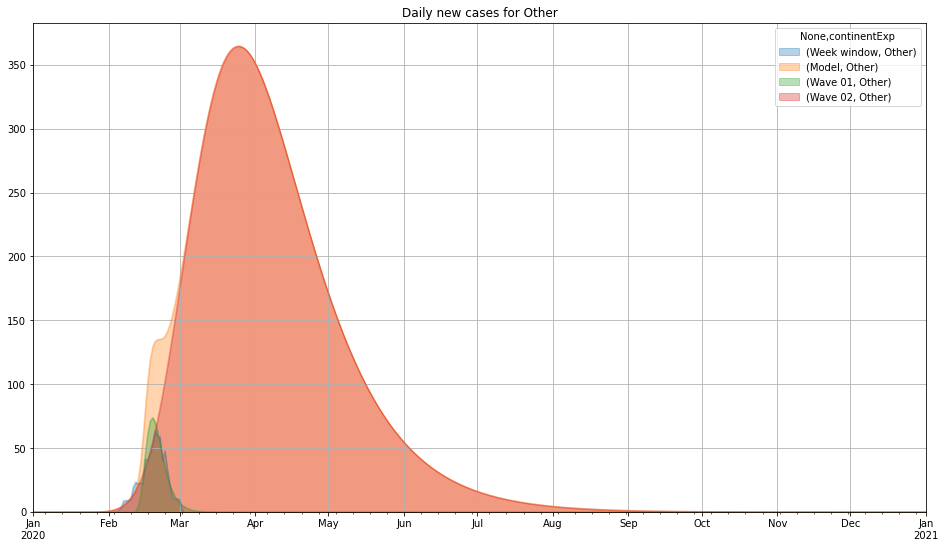

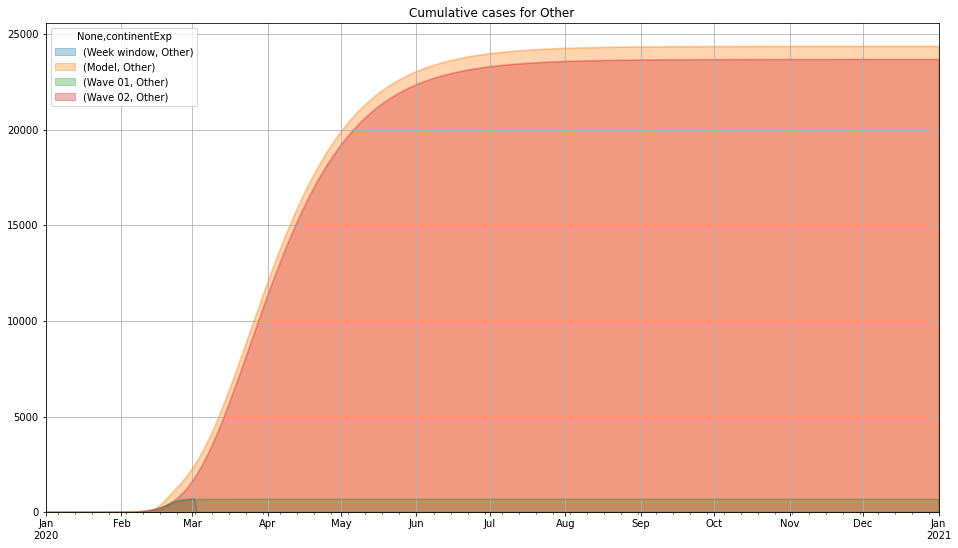

In [10]:
# Select countries to fit.
countries = np.sort(df['continentExp'].unique())
#countries = ['RS', 'IL', 'US', 'UK', 'BR', 'CH', 'DE', 'IT', 'ES', 'PT', 'FR', 'SE',
#             'NO', 'DK', 'BE', 'NL', 'NZ', 'CN', 'JP', 'RU', 'AT', 'ZA', 'IN', 'KW',
#             'AU', 'BO', 'SD', 'SI']

#countries = ['BB', 'BI', 'BM', 'BZ', 'CF', 'IS', 'JE', 'LV', 'ML', 'NO', 'PF', 'VC']

# Choose whether to output plots per country.
showplots = True

measure  = 'cases'
smeasure = 'Week window' # smoothed
rmeasure = 'rcases'      # remaining
pmeasure = 'Model'       # predicted
wmeasure = 'Wave '       # waves

for country in countries:

    wave = 1

    df_geo[(pmeasure, country)] = 0
    df_geo[(smeasure, country)] = df_geo[measure][country].loc[:].rolling(7).mean()
    df_geo[(rmeasure, country)] = df_geo[smeasure][country]

    plotlist = [(smeasure, country), (pmeasure, country)]

    #countryname = df[df['geoId'] == country]['countriesAndTerritories'].iloc[0]
    #popdata = df[df['geoId'] == country]['popData2019'].iloc[0]

    #mincases = popdata / 1e6
    mincases = 2
    #mincases = df_geo[smeasure][country].sum() / 5000

    print('Running multiple wave analysis for {}'.format(country))
    print('Minimum number of cases is {:1.0f}'.format(mincases))

    while True:
        #print('Analyzing wave {:1.0f}'.format(wave))
        curwave = wmeasure + str((wave) + 1000)[-2:]
        df_geo[(curwave, country)] = 0

        df_pred = pd.DataFrame({'daynum':df_geo['daynum'],
                                measure:df_geo[rmeasure][country]})
        #df_pred[df_pred[measure].notnull()].plot(x='daynum', y=measure, figsize=(16, 9), grid=True)

        df_pred['gumdiv'] = df_pred[measure] / df_pred[measure].cumsum()
        df_pred = df_pred[(df_pred['gumdiv'] > 0) & (df_pred[measure] > mincases)]

        df_pred['linear'] = np.log(df_pred['gumdiv'])

        df_pred = df_pred[(df_pred['linear'] < -0.5) &
                          (df_pred['linear'] > -4.5)]

        #df_pred['linear'].plot(figsize=(16, 9), grid=True)

        if len(df_pred) <= 1:
            print('--- no data left')
            break

        X = df_pred['daynum'].values.reshape(-1, 1)
        y = df_pred['linear'].values.reshape(-1, 1)

        #model = Earth(minspan=0)
        model = Earth(minspan=1, penalty=0, endspan=0, thresh=1e-9, check_every=1)
        model.fit(X, y)

        #print(model.trace())
        #print(model.summary())

        df_pred['earth'] = model.predict(X)

        daymin = df_pred['daynum'].min()
        daymax = df_pred['daynum'].max()
        #print('From {} to {}'.format(daymin, daymax))

        #df_pred.plot(x='daynum', y=['linear', 'earth'], figsize=(16, 9), grid=True)

        #df_pred['gbgrad'] = np.gradient(df_pred['linear'])
        #df_pred['eagrad'] = np.gradient(df_pred['earth'])
        df_pred['gbgrad'] = df_pred['linear'] - df_pred['linear'].shift(1)
        df_pred['eagrad'] = df_pred['earth'] - df_pred['earth'].shift(1)

        #df_pred['gbgrad'] = df_pred['linear'] - df_pred['linear'].shift(1)
        #df_pred['eagrad'] = df_pred['earth'] - df_pred['earth'].shift(1)

        #df_pred.plot(x='daynum', y=['gbgrad', 'eagrad'], figsize=(16, 9), grid=True)

        fitmod = export.export_python_function(model)
        #print(export.export_python_string(model))

        df_pred['knot'] = ((abs(df_pred['eagrad'] - df_pred['eagrad'].shift(1)) > 1e-6) |
                           (df_pred['daynum'] == (daymin + 1)) |
                           (df_pred['daynum'] == daymax))
        df_pred['daycount'] = df_pred.reset_index().index
        #df_pred[df_pred['knot']]

        df_knot = df_pred[df_pred['knot']][['daynum', 'daycount', 'eagrad']]
        df_knot['days'] = df_knot['daycount'].shift(-1) - df_knot['daycount']
        #df_knot = df_knot[(df_knot['days'] >= 5)]
        #df_knot['eadiff'] = df_knot['eagrad'] - df_knot['eagrad'].shift(1)
        #df_knot

        df_knot['cand'] = ((df_knot['eagrad'] < -1/30) &
                           (df_knot['days'] >= 3))
        #df_knot

        df_knot['since'] = df_knot['daynum'] - daymin

        #df_knot['score'] = - df_knot['eagrad']
        #df_knot['score'] = (df_knot['eagrad'] ** 2) * df_knot['days'] / np.sqrt(df_knot['since'])
        df_knot['score'] = (df_knot['eagrad'] ** 2) * np.sqrt(df_knot['days'] / np.sqrt(df_knot['since']))

        df_knot['choice'] = df_knot['score'] == df_knot[df_knot['cand']]['score'].max()
        #df_knot

        choice = df_knot[df_knot['choice']]
        if len(choice) == 0:
            print('--- no data for wave')
            break

        lower = choice['daynum'].values[0]
        upper = choice['days'].values[0] + lower
        #print('From {} to {}'.format(lower, upper))

        #lower = 185
        #upper = 187

        df_pred = df_pred[(df_pred['daynum'] >= lower) &
                          (df_pred['daynum'] <= upper)].copy()

        slope = (fitmod([[upper]])[0] - fitmod([[lower]])[0]) / (upper - lower)
        intercept = fitmod([[lower]])[0] - (lower * slope)

        #print('From {} to {} with slope {:1.4f} and intercept {:1.3f}'.format(
        #    lower, upper, slope, intercept))

        beta = - 1 / slope
        mu = beta * (intercept + np.log(beta))

        df_pred['pgumb'] = gumpdf(df_pred['daynum'], beta, mu)
        df_pred['scale'] = df_pred[measure] / df_pred['pgumb']

        final = df_pred['scale'].mean()

        print('{} beta {:6.3f} with mu {:3.0f} from {:3.0f} to {:3.0f} for {:1.0f}'.format(
            curwave, beta, mu, lower, upper, final))

        df_geo[(curwave, country)] = final * gumpdf(df_geo['daynum'], beta, mu)
        df_geo[(pmeasure, country)] += df_geo[(curwave, country)]
        df_geo[(rmeasure, country)] -= df_geo[(curwave, country)]
        plotlist += [(curwave, country)]
        wave += 1

    df_geo[plotlist].loc['20200101':'20210101'].plot(
        figsize=(16, 9), grid=True, kind='area', stacked=False, alpha=1/3, title='Daily new cases for '+country)

    df_geo[plotlist].loc['20200101':'20210101'].cumsum().plot(
        figsize=(16, 9), grid=True, kind='area', stacked=False, alpha=1/3, title='Cumulative cases for '+country)

We have the estimate for the final number of cases, so the progress would be the current number of cases divided by the final number. This could end up over 100%, if we estimate that the current wave of the outbreak is over and new cases are due to relaxing of measures, increase in testing or other factors.

In [11]:
progress = df_geo[measure][country].sum() / df_geo[pmeasure][country].sum()
print('Currently at {:1.2f}% of {:1.0f}'.format(progress * 100, df_geo[pmeasure][country].sum()))

Currently at 2.86% of 24353


The peak can be found at the first predicted value that is larger than the next.

In [12]:
peak = df_geo[df_geo[(pmeasure, country)] == df_geo[(pmeasure, country)].max()].index.min()
print('Peak at {}'.format(peak.date()))

Peak at 2020-03-25


This date should closely match the `mu` of our distribution, in days since the start of the index.

In [13]:
print('Peak by last mu at {}'.format(df_geo.loc[df_geo['daynum'] == mu.astype(int)].index[0].date()))

Peak by last mu at 2020-03-25


The floor is defined as the first time that the number of reported cases falls below 1 in a million, which is the first time that happens *after* the peak.

In [14]:
floor = df_geo[(df_geo[(pmeasure, country)] < (popdata / 1e6)) &
               (df_geo[(pmeasure, country)].index > peak)].index.min()
print('Floor at {}'.format(floor.date()))

NameError: name 'popdata' is not defined

Similarly, we can calculate the start as the first day where the number of cases was above 1 in a million before the peak.

In [ ]:
start = df_geo[(df_geo[(pmeasure, country)] > (popdata / 1e6)) &
               (df_geo[(pmeasure, country)].index < peak)].index.min()
print('Start at {}'.format(start.date()))

We define the maximum delta as the day in the curve with the sharpest rise.

In [ ]:
maxrise = (df_geo[(pmeasure, country)] - df_geo[(pmeasure, country)].shift()).max()
maxdelta = df_geo[(df_geo[(pmeasure, country)] - df_geo[(pmeasure, country)].shift()) == (
    maxrise)].index.min()
print('Largest rise of {:1.0f} on {}'.format(maxrise, maxdelta.date()))

This should match the maximum gradient of the daily data.

In [ ]:
print('Maximum gradient is {:1.0f}'.format(np.gradient(df_geo[(pmeasure, country)]).max()))

Back to the original curve, showing the number of infected concurrently.

In [ ]:
df_geo[pmeasure][country].rolling(14).sum().loc[start:floor].plot()

The top of this curve gives the maximum number of people that are infected at the same time.

In [ ]:
print('Maximum infected is {:1.0f}'.format(df_geo[pmeasure][country].rolling(14).sum().max()))

If we look at the difference between our actual (smoothed) value and our prediction, we can clearly see if the curve is breaking out after the floor. This can be the result of relaxing of measures and the beginning of a second wave, an increase in testing or other factors.

In [ ]:
(df_geo[(smeasure, country)] - df_geo[(pmeasure, country)]).loc[:].plot()

Keep exploring! Stay home, wash your hands, keep your distance.